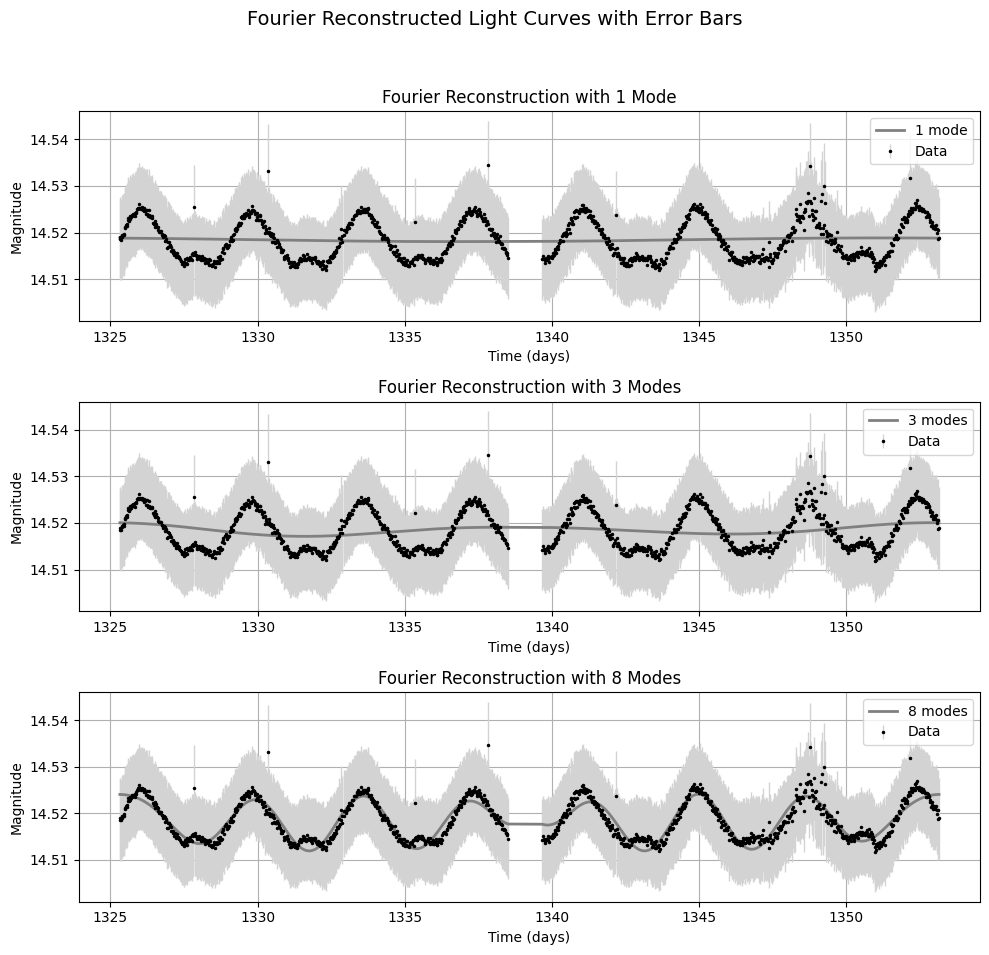

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---- Step 1: Load the TESS light curve ----

file_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended/_lc_median_after_cbv_detrended_ACV/308452159_sector01_4_3.lc"

# Read the light curve file 
df = pd.read_csv(file_path, sep='\s+', names=["time", "mag_clean", "mag", "magerr"])
time = df["time"].values
mag = df["mag_clean"].values
magerr = df["magerr"].values
# mag -= np.mean(mag)  # Remove mean

# ---- Step 2: Apply Fourier Transform ----

fft_mag = np.fft.fft(mag)

# ---- Step 3: Reconstruct and Plot for k = 1, 3, 8 modes ----

kvals = [1, 3, 8]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4)

for k, subplot in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Keep only k modes
    fft_copy = np.copy(fft_mag)
    fft_copy[k + 1:-k] = 0
    mag_reconstructed = np.fft.ifft(fft_copy).real

    # Plot data points in black
    ax.errorbar(time, mag, yerr=magerr, fmt='.', color='black', ecolor='lightgray', elinewidth=1, markersize=3, label='Data')

    # Plot reconstructed curve
    ax.plot(time, mag_reconstructed, color='gray', lw=2, label=f'{k} mode{"s" if k > 1 else ""}')

    ax.set_title(f"Fourier Reconstruction with {k} Mode{'s' if k > 1 else ''}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Magnitude")
    ax.grid(True)
    ax.legend()

plt.suptitle("Fourier Reconstructed Light Curves with Error Bars", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
file_name = os.path.basename(file_path)  # e.g., '308452159_sector01_4_3.lc'
plot_dir = os.path.join("/home/devika/PhD/S1/Astroinformatics/Project/Results", "fourier_reconstruction")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, file_name.replace(".lc", "_FT.pdf")))
plt.show()


Best period: 0.01045 days


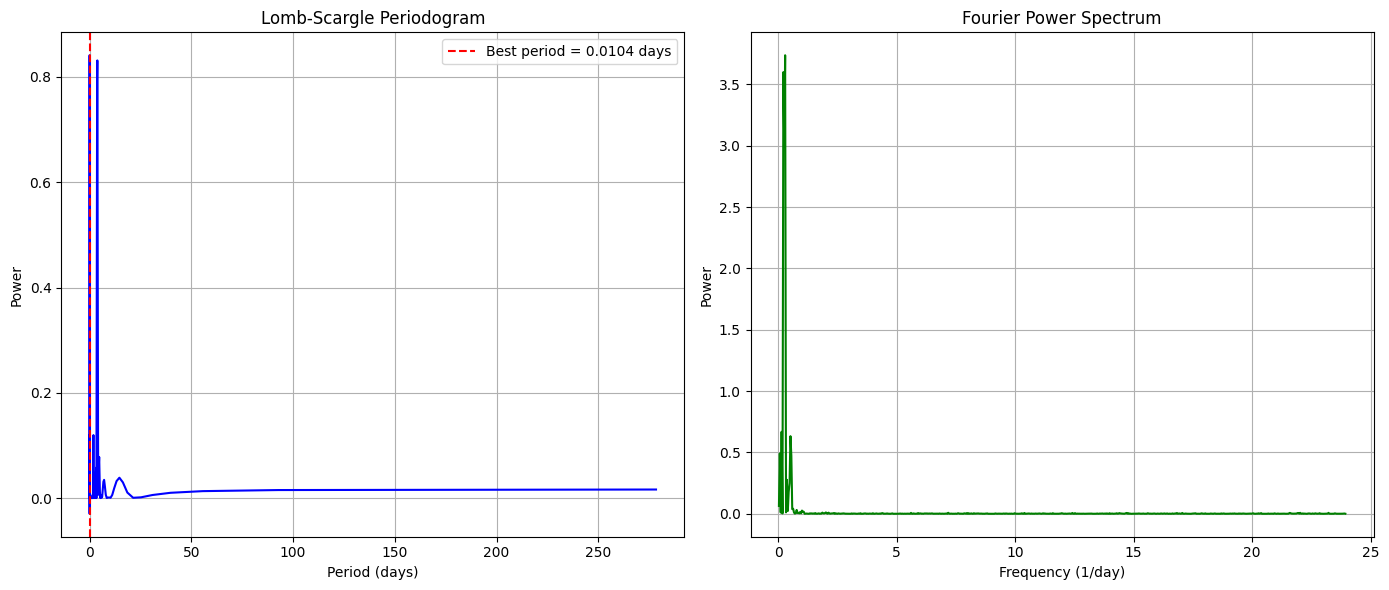

In [6]:
from astropy.timeseries import LombScargle

# ---- Step 1: Load TESS Light Curve Data ----

file_path = "/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended/_lc_median_after_cbv_detrended_ACV/308452159_sector01_4_3.lc"

# Load the light curve data 
df = pd.read_csv(file_path, sep='\s+', names=["time", "mag_clean", "mag", "magerr"])

# Use cleaned magnitude
time = df["time"].values
mag = df["mag_clean"].values

# ---- Step 2: Lomb-Scargle Periodogram ----

frequency, power = LombScargle(time, mag).autopower()
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

print(f"Best period: {best_period:.5f} days")

# ---- Step 3: Fourier Transform ----

# Apply FFT
fft_result = np.fft.fft(mag)
fft_freq = np.fft.fftfreq(len(time), d=(np.median(np.diff(time))))

# Keep only positive frequencies
positive = fft_freq > 0
fft_freq = fft_freq[positive]
fft_power = np.abs(fft_result[positive])**2

# ---- Step 4: Plotting Results ----

plt.figure(figsize=(14, 6))

# Lomb-Scargle plot
plt.subplot(1, 2, 1)
plt.plot(1/frequency, power, color="blue")
plt.axvline(best_period, color="red", linestyle="--", label=f"Best period = {best_period:.4f} days")
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.legend()
plt.grid(True)

# Fourier power spectrum
plt.subplot(1, 2, 2)
plt.plot(fft_freq, fft_power, color="green")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Fourier Power Spectrum")
plt.grid(True)

plt.tight_layout()
file_name = os.path.basename(file_path)  # e.g., '308452159_sector01_4_3.lc'
plot_dir = os.path.join("/home/devika/PhD/S1/Astroinformatics/Project/Results", "LS")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, file_name.replace(".lc", "_LS.pdf")))

plt.show()


Best period (constrained): 3.76548 days


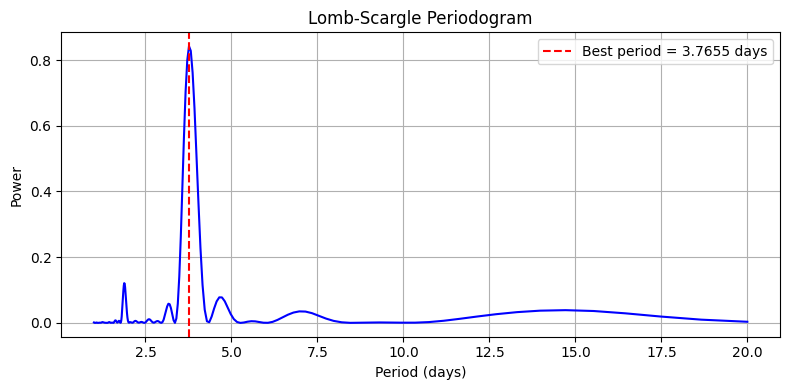

In [7]:
from astropy.timeseries import LombScargle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(file_path, sep='\s+', names=["time", "mag_clean", "mag", "magerr"])
time = df["time"].values
mag = df["mag_clean"].values

# Set period search range (1 to 20 days here as an example)
min_period = 1.0  # in days
max_period = 20.0
min_frequency = 1 / max_period
max_frequency = 1 / min_period

# Compute periodogram with constraints
ls = LombScargle(time, mag)
frequency, power = ls.autopower(minimum_frequency=min_frequency,
                                 maximum_frequency=max_frequency,
                                 samples_per_peak=10)

# Best period
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"Best period (constrained): {best_period:.5f} days")

# Plot periodogram
plt.figure(figsize=(8, 4))
plt.plot(1 / frequency, power, color='blue')
plt.axvline(best_period, color='red', linestyle='--', label=f"Best period = {best_period:.4f} days")
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Apply Lomb-Scargle period search with constrained frequency, saving periodogram plots and collecting best-fit periods for all light curves for all folders under _TESS_lightcurves_median_after_detrended
[Runs Lomb-Scargle constrained to 0.1–20 day periods]

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

base_dir = "/home/devika/PhD/S1/Astroinformatics/Project/_data/_TESS_lightcurves_median_after_detrended"

results = []

# Define period range constraints (days)
min_period = 0.1
max_period = 20.0
min_freq = 1 / max_period
max_freq = 1 / min_period

for folder in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    print(f"Processing folder: {folder}")
    
    for file in sorted(os.listdir(folder_path)):
        if not file.endswith(".lc"):
            continue
        
        file_path = os.path.join(folder_path, file)
        
        try:
            df = pd.read_csv(file_path, sep='\s+', names=["time", "mag_clean", "mag", "magerr"])
            time = df["time"].values
            mag = df["mag_clean"].values
            
            if len(time) < 10 or np.any(np.isnan(mag)):
                print(f"Skipping {file} (insufficient or invalid data)")
                continue
            
            # Lomb-Scargle with period constraints
            ls = LombScargle(time, mag)
            frequency, power = ls.autopower(minimum_frequency=min_freq,
                                            maximum_frequency=max_freq,
                                            samples_per_peak=10)
            
            periods = 1 / frequency
            best_idx = np.argmax(power)
            best_period = periods[best_idx]
            best_power = power[best_idx]
            
            results.append({
                "file": file,
                "folder": folder,
                "best_period": best_period,
                "max_power": best_power,
                "n_points": len(time)
            })
            
            # Plot periodogram
            plt.figure(figsize=(8, 4))
            plt.plot(periods, power, color="blue", label="LS Power")
            plt.axvline(best_period, color="red", linestyle="--", label="Best Period")
            plt.text(best_period, best_power * 0.85,
                     f"{best_period:.4f} d", color="red", ha="center",
                     bbox=dict(boxstyle="round", fc="white", ec="red"))
            plt.xlabel("Period (days)")
            plt.ylabel("Power")
            plt.title(f"{file} ({folder})")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            
            plot_dir = os.path.join("/home/devika/PhD/S1/Astroinformatics/Project/Results/periodogram_plots", folder)
            os.makedirs(plot_dir, exist_ok=True)
            plt.savefig(os.path.join(plot_dir, file.replace(".lc", "_periodogram.pdf")))
            plt.close()
            
            print(f"✅ {folder}/{file}: Best Period = {best_period:.5f} days")
        
        except Exception as e:
            print(f"⚠️ Error in {folder}/{file}: {e}")

# Save results CSV
results_df = pd.DataFrame(results)
results_df.to_csv("TESS_all_best_periods.csv", index=False)
print("✅ Saved all results to TESS_all_best_periods.csv")


Processing folder: _lc_median_after_cbv_detrended_ACV
✅ _lc_median_after_cbv_detrended_ACV/238869272_sector01_3_2.lc: Best Period = 4.15936 days
✅ _lc_median_after_cbv_detrended_ACV/270304671_sector01_1_3.lc: Best Period = 7.97141 days
✅ _lc_median_after_cbv_detrended_ACV/277688819_sector01_2_1.lc: Best Period = 8.20633 days
✅ _lc_median_after_cbv_detrended_ACV/306893839_sector01_4_3.lc: Best Period = 4.22248 days
✅ _lc_median_after_cbv_detrended_ACV/308452159_sector01_4_3.lc: Best Period = 3.76548 days
✅ _lc_median_after_cbv_detrended_ACV/309148260_sector01_4_3.lc: Best Period = 13.97486 days
✅ _lc_median_after_cbv_detrended_ACV/327597288_sector01_2_1.lc: Best Period = 1.78512 days
✅ _lc_median_after_cbv_detrended_ACV/348898673_sector01_4_3.lc: Best Period = 5.06826 days
✅ _lc_median_after_cbv_detrended_ACV/349409844_sector01_4_3.lc: Best Period = 0.41547 days
✅ _lc_median_after_cbv_detrended_ACV/350146577_sector01_4_3.lc: Best Period = 1.83213 days
✅ _lc_median_after_cbv_detrended_AC